# Vector autoregression
This Jupyter Notebook builds Vector Autoregression model (VAR), to understand the linear relationships between multiple time series variables. The notebook will guide you through the process of building a VAR model, which can be used for forecasting enrolled students at the Univerity of Tübingen.

In [1]:
# To make relative imports work in notebooks
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
 
# actual imports
from src.constants import YEARS, FIG_DIR, COL_STUDENT, COL_SALARY, COL_STUDENT_PRED, COL_SALARY_PRED, COURSES, SECTORS
from src.dataLoading import getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedGrossSalaries
from src.model import fitVarModel, predict
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from tueplots import bundles
import pandas as pd

### Load data
Load the data for all three time-series.
Values range form 2007 to 2021 (inlcuding). This is limited by the salary data.

Load enrolled students for specified courses.

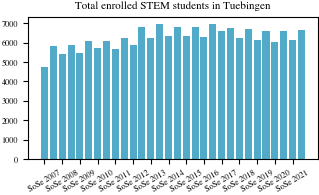

In [2]:
interestingYears = YEARS[3:-4]

totalStudents = getTotalStudentsFor(courses = COURSES, years = interestingYears)

# Plotting
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.bar(interestingYears, totalStudents, color=COL_STUDENT)
plt.xticks(ticks=interestingYears[::2], rotation=30)
plt.title(f'Total enrolled STEM students in Tuebingen')
plt.show()

Load inflation adjusted gross salary data for specified sector.

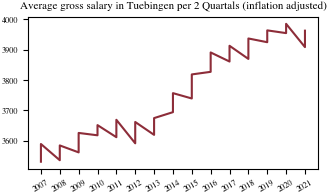

In [3]:
inflationAdjasutedGrossSalary = getInflationAdjustedGrossSalaries(SECTORS)
salaries = getSalaries()
salary_YEARS = salaries.index.levels[1]

plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.plot(salary_YEARS.repeat(2), inflationAdjasutedGrossSalary, color=COL_SALARY)
plt.xticks(ticks=salary_YEARS, rotation=30)
plt.title('Average gross salary in Tuebingen per 2 Quartals (inflation adjusted)')
plt.show()

/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


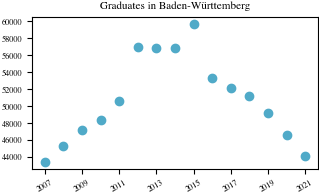

In [4]:
years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)


plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.scatter(years, graduatesInBW, color=COL_STUDENT)
plt.xticks(ticks=years[::2], rotation=30)
plt.title('Graduates in Baden-Württemberg')
plt.show()

### Simple VAR-Modell for one subject, with data per semester

The data ranges from 2007 to (including) 2021.
Limited by the salary data.

In [5]:
LAGS = 4
PREDICTION_STPES = 10

In [6]:
results = fitVarModel(totalStudents, inflationAdjasutedGrossSalary, graduatesInBW, lags=LAGS)
forecast, _, _ = predict(results, 10)

/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/paulkaifler/miniconda3/envs/dataLiteracy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


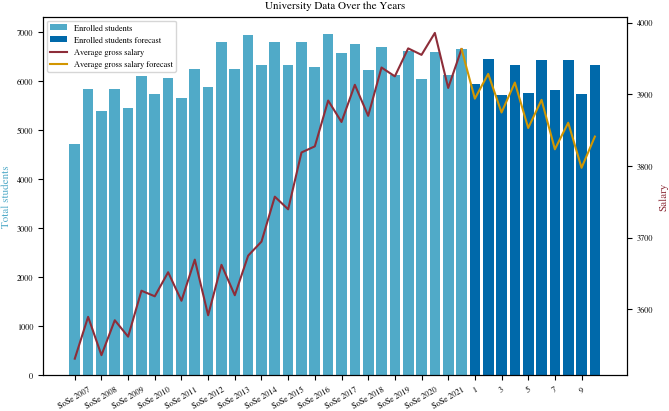

In [7]:
data = np.column_stack((totalStudents, inflationAdjasutedGrossSalary, graduatesInBW.repeat(2)))
dataWithForecast = np.vstack((data, forecast))
yearsWithForecast = np.append(interestingYears, [f"{i+1}" for i in range(PREDICTION_STPES)])

plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=1, usetex=False))
fig, ax1 = plt.subplots()
plt.title('University Data Over the Years')
plt.xticks(rotation=30)


ax1.set_ylabel('Total students', color=COL_STUDENT)
# Plot main data
ax1.bar(yearsWithForecast[:-len(forecast)], dataWithForecast[:-len(forecast), 0], color=COL_STUDENT, label='Enrolled students')

# Plot forecast with a different color
ax1.bar(yearsWithForecast[-len(forecast):], dataWithForecast[-len(forecast):, 0], color=COL_STUDENT_PRED, label='Enrolled students forecast')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Salary', color=COL_SALARY)

# Plot main data
ax2.plot(yearsWithForecast[:-len(forecast)], dataWithForecast[:-len(forecast), 1], color=COL_SALARY, label='Average gross salary')

# Plot forecast with a different color
ax2.plot(yearsWithForecast[-len(forecast) - 1:], dataWithForecast[-len(forecast) - 1:, 1], color=COL_SALARY_PRED, label='Average gross salary forecast')

# Create one legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Get current ticks, keep only every second tick
locs, labels = plt.xticks()
plt.xticks(locs[::2], labels[::2])

plt.savefig(FIG_DIR + '/predictingStudents.pdf')
plt.show()